# Importing Librarires 

In [1]:
# Libraries and dependencies:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, RFE, chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve ,auc, precision_score,recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Exploratory Data Analysis:

In [2]:
# importing Dataset:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.shape

(5110, 12)

In [5]:
df.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [6]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [7]:
df.isnull().sum()/len(df)*100

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [8]:
mean_stroke = round(df[df.stroke == 1]['bmi'].mean())
mean_healthy = round(df[df.stroke == 0]['bmi'].mean())
mean_healthy

29

In [9]:
df['bmi'] = np.where((df.bmi.isnull()) & (df.stroke == 1), mean_stroke,df['bmi'])
df['bmi'] = np.where((df.bmi.isnull()) & (df.stroke == 0 ),mean_healthy,df['bmi'])

In [10]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [11]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [12]:
obj_col = df.select_dtypes(include='object')
obj_col.nunique()

gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64

In [13]:
obj_col[(obj_col.gender != 'Male') & (obj_col.gender != 'Female')]

,gender,ever_married,work_type,Residence_type,smoking_status
3116,Other,No,Private,Rural,formerly smoked


In [14]:
df.drop(df[(df.gender!='Male') & (df.gender != 'Female')].index,inplace=True)

In [15]:
df.shape

(5109, 12)

In [16]:
target_balance = df.stroke.value_counts()
target_balance = pd.DataFrame(target_balance)
print(f"The unbalanced state in terms of percentage, no-stroke: {round(target_balance['count'][0]/len(df),2)*100}%, stroke: {round(target_balance['count'][1]/len(df),2)*100}%")

The unbalanced state in terms of percentage, no-stroke: 95.0%, stroke: 5.0%


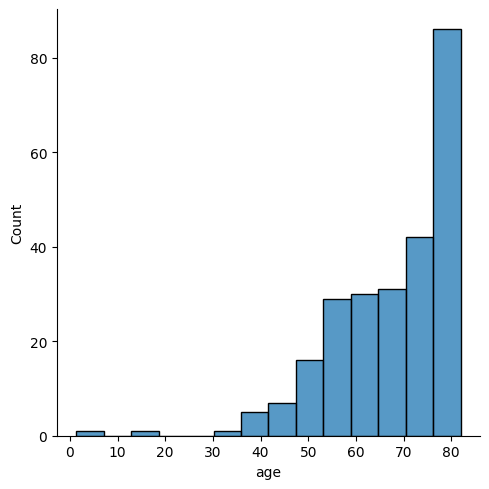

In [17]:
sns.displot(df[df.stroke == 1.0]['age'])
plt.show();

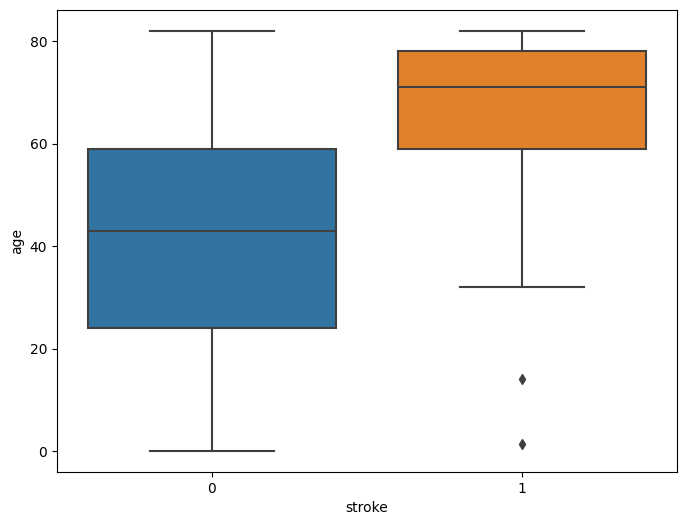

In [18]:
plt.figure(figsize=(8,6))
sns.boxplot(x='stroke',y='age',data=df)
plt.show();

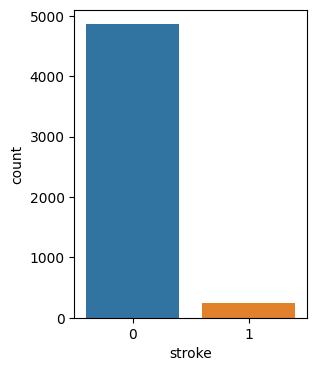

In [19]:
plt.figure(figsize=(3,4))
sns.barplot(data=target_balance,x=target_balance.index,y='count',)
plt.show();

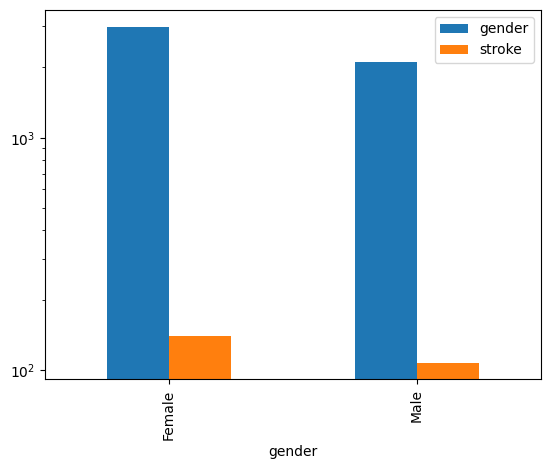

In [20]:
gender_representation = df.groupby('gender').agg({'gender':'count','stroke':'sum'})
gender_representation.plot(kind='bar')
plt.yscale('log')
plt.show();

In [21]:
numerical_data = (df.select_dtypes(exclude='object')).drop(columns = ['id','hypertension','heart_disease','stroke'])

In [22]:
numerical_data['stroke'] = df['stroke']

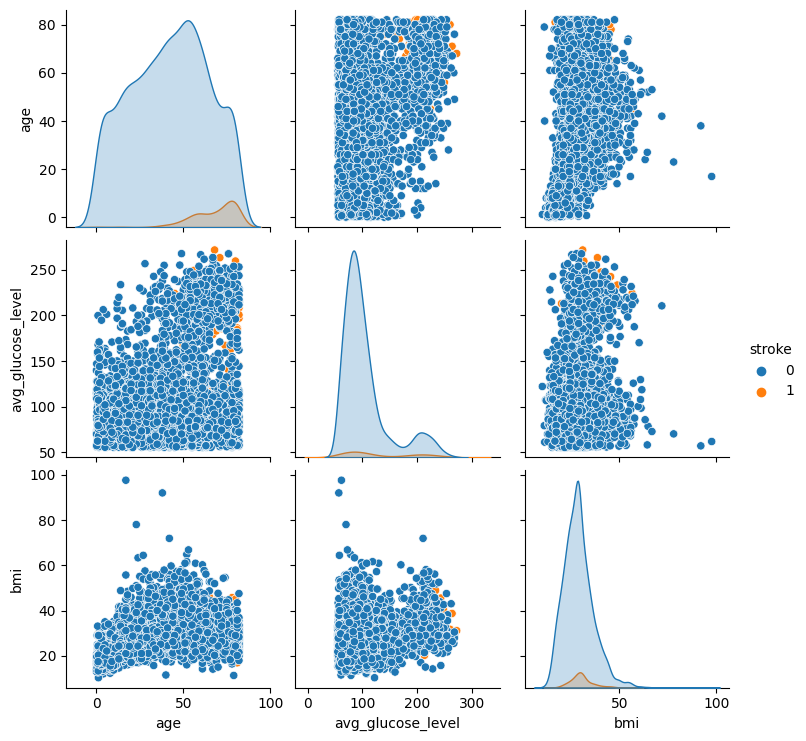

In [23]:
sns.pairplot(numerical_data,hue='stroke',)
plt.show();

# Data Preprocessing:

In [28]:
q1 = df[df['stroke']==1]['age'].quantile(0.25)
q3 = df[df['stroke']==1]['age'].quantile(0.75)
iqr = q3-q1
lower_bound = q1 -1.5*iqr
upper_bound = q3 + 1.5*iqr
lower_bound,upper_bound
outliers = df[(df['age'] < lower_bound)]
df = df.drop(outliers.index,axis=0)

In [29]:
len(df)

3540

## Encoding : 

In [30]:
to_encode = df.select_dtypes(include='object')
encode_columns = to_encode.columns

In [31]:
encode_columns

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [32]:
encoder_one_hot = OneHotEncoder(sparse=False,drop='first')
oh_encoded = encoder_one_hot.fit_transform(df[encode_columns])

In [33]:
oh_encoded = pd.DataFrame(oh_encoded,columns = encoder_one_hot.get_feature_names_out(input_features=encode_columns))

In [34]:
df = df.drop(columns=encode_columns)

In [35]:
df_encoded = pd.concat([df,oh_encoded],axis=1,join='inner')
df_encoded.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,51676,61.0,0,0,202.21,30.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,31112,80.0,0,1,105.92,32.5,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,60182,49.0,0,0,171.23,34.4,1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1665,79.0,1,0,174.12,24.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [36]:
df_encoded.shape

(2490, 15)

In [37]:
df_encoded.isna().sum()

id                                0
age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
stroke                            0
gender_Male                       0
ever_married_Yes                  0
work_type_Private                 0
work_type_Self-employed           0
Residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [38]:
df_encoded = df_encoded.drop(columns='id')

## Scaling:

In [39]:
x,y = df_encoded.drop(columns='stroke'),df_encoded['stroke']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

In [40]:
X_scaled[0]

array([ 0.74091402, -0.41244731,  3.26121358,  2.27891025,  0.84892269,
        1.22372075,  0.34874292,  0.79480621, -0.5312093 ,  0.97933004,
        1.85006361, -0.82060167, -0.46903113])

## Training and Testing Sets:

In [41]:
desired_ratio = 0.20

minority_class_samples = len(y[y == 1])
majority_class_samples = int(minority_class_samples / desired_ratio)
sampling_strategy = {
    0: majority_class_samples,  
    1: minority_class_samples,  
}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_scaled, y)
y_resampled.value_counts()

stroke
0    1235
1     247
Name: count, dtype: int64

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.20,stratify=y_resampled,random_state=10)

In [43]:
y_train.value_counts() , y_test.value_counts()

(stroke
 0    988
 1    197
 Name: count, dtype: int64,
 stroke
 0    247
 1     50
 Name: count, dtype: int64)

## Resampling:

In [44]:
smote = SMOTE(sampling_strategy={0: 996,1:300}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
y_resampled.value_counts()

stroke
0    996
1    300
Name: count, dtype: int64

In [45]:
y_resampled.value_counts(),y_test.value_counts()

(stroke
 0    996
 1    300
 Name: count, dtype: int64,
 stroke
 0    247
 1     50
 Name: count, dtype: int64)

# Model Selection:

In [46]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### Without GridSearchCV

In [47]:
estimators_nogs = [
    ('random_forest', RandomForestClassifier()),
    ('svm', SVC()),
    ('logistic_regression', LogisticRegression()),
    ('Decision_tree',DecisionTreeClassifier()),
    ('SGD', SGDClassifier())
]

param_grids_nogs = {
    'random_forest': {
    },
    'svm': {
    },
    'logistic_regression': {
    },
    'Decision_tree': {
    },
    'SGD': {
    }
}
best_models_nogs = {}
for name, estimator in estimators_nogs:
    grid_search = GridSearchCV(estimator,param_grids_nogs[name],scoring =['accuracy','precision','recall'],refit='precision',cv=3,n_jobs=-1)
    grid_search.fit(X_resampled,y_resampled)
    best_models_nogs[name] = [grid_search.best_estimator_,grid_search.best_score_]


In [48]:
best_models_nogs

{'random_forest': [RandomForestClassifier(), 0.68495995995996],
 'svm': [SVC(), 0.6177606177606177],
 'logistic_regression': [LogisticRegression(), 0.4936868686868687],
 'Decision_tree': [DecisionTreeClassifier(), 0.4199176621868259],
 'SGD': [SGDClassifier(), 0.4134961586973971]}

### With GridSearchCV

In [49]:
estimators_gs = [
    ('random_forest', RandomForestClassifier()),
    ('svm', SVC()),
    ('logistic_regression', LogisticRegression()),
    ('Decision_tree',DecisionTreeClassifier()),
    ('SGD', SGDClassifier())
     
]

# Define a parameter grid for each estimator
param_grids_gs = {
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'logistic_regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2']
    },
    'Decision_tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'SGD': {
        'loss': ['hinge', 'log', 'perceptron'],
        'penalty': ['l1', 'l2', 'elasticnet']
    }
}


In [50]:
best_models_gs = {}
model = []
for name, estimator in estimators_gs:
    grid_search = GridSearchCV(estimator,param_grids_gs[name],scoring =['accuracy','precision','recall'],refit='precision',cv=3,n_jobs=-1)
    grid_search.fit(X_resampled,y_resampled)
    best_models_gs[name] = [grid_search.best_estimator_,grid_search.best_score_,grid_search.best_params_]

In [51]:
best_models_gs

{'random_forest': [RandomForestClassifier(max_depth=10, n_estimators=200),
  0.7106782106782106,
  {'max_depth': 10, 'n_estimators': 200}],
 'svm': [SVC(C=1), 0.6177606177606177, {'C': 1, 'kernel': 'rbf'}],
 'logistic_regression': [LogisticRegression(C=10),
  0.5034992784992784,
  {'C': 10, 'penalty': 'l2'}],
 'Decision_tree': [DecisionTreeClassifier(max_depth=10, min_samples_split=10),
  0.45684922922672017,
  {'max_depth': 10, 'min_samples_split': 10}],
 'SGD': [SGDClassifier(penalty='l1'),
  0.4759800231498345,
  {'loss': 'hinge', 'penalty': 'l1'}]}

### Feature Selection

In [52]:
num_feats = 5
feature_name = list(x.columns)
embedded_rf_support = SelectFromModel(RandomForestClassifier(n_estimators=100),max_features = num_feats).fit(MinMaxScaler().fit_transform(X_train), y_train).get_support()
embedded_lr_support = SelectFromModel(LogisticRegression(penalty='l1',solver = 'liblinear',max_iter = 100),max_features = num_feats).fit(MinMaxScaler().fit_transform(X_train), y_train).get_support()
chi_support = SelectKBest(chi2, k = num_feats).fit(MinMaxScaler().fit_transform(X_train), y_train).get_support() 
rfe_support = RFE(estimator=LogisticRegression(),n_features_to_select=num_feats,step=10,).fit(MinMaxScaler().fit_transform(X_train),y_train).get_support()
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embedded_lr_support,'Random Forest':embedded_rf_support})
feature_selection_df['Total'] = np.sum(feature_selection_df == True, axis=1)
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
best_features = feature_selection_df.Feature[:num_feats].to_list()
best_features

['avg_glucose_level',
 'age',
 'smoking_status_formerly smoked',
 'heart_disease',
 'bmi']

In [53]:
X_train_fs,X_test_fs=[],[]
for i in best_features:
    X_train_fs.append(X_train[:,x.columns.to_list().index(i)])
    X_test_fs.append(X_test[:,x.columns.to_list().index(i)])
X_train_fs,X_test_fs= np.transpose(X_train_fs), np.transpose(X_test_fs)


In [54]:
X_train.shape,X_train_fs.shape

((1185, 13), (1185, 5))

In [55]:
estimators_fs = [
    ('random_forest', RandomForestClassifier()),
    ('svm', SVC()),
    ('logistic_regression', LogisticRegression()),
    ('Decision_tree',DecisionTreeClassifier()),
    ('SGD', SGDClassifier())
     
]

# Define a parameter grid for each estimator
param_grids_fs = {
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'logistic_regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2']
    },
    'Decision_tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'SGD': {
        'loss': ['hinge', 'log', 'perceptron'],
        'penalty': ['l1', 'l2', 'elasticnet']
    }
}


In [56]:
best_models_fs = {}
for name, estimator in estimators_fs:
    grid_search = GridSearchCV(estimator,param_grids_fs[name],scoring =['accuracy','precision','recall'],refit='precision',cv=3,n_jobs=-1)
    grid_search.fit(X_train_fs,y_train)
    best_models_fs[name] = [grid_search.best_estimator_,grid_search.best_score_,grid_search.best_params_]


In [57]:
best_models_fs

{'random_forest': [RandomForestClassifier(max_depth=10),
  0.6109098228663447,
  {'max_depth': 10, 'n_estimators': 100}],
 'svm': [SVC(C=10), 0.4031328320802005, {'C': 10, 'kernel': 'rbf'}],
 'logistic_regression': [LogisticRegression(C=0.1),
  0.5,
  {'C': 0.1, 'penalty': 'l2'}],
 'Decision_tree': [DecisionTreeClassifier(max_depth=10, min_samples_split=10),
  0.3871289162814586,
  {'max_depth': 10, 'min_samples_split': 10}],
 'SGD': [SGDClassifier(loss='perceptron', penalty='elasticnet'),
  0.3476233963905197,
  {'loss': 'perceptron', 'penalty': 'elasticnet'}]}

# Compare

In [58]:
performance_gs = pd.DataFrame(best_models_gs).T.rename(columns={0:'estimator_GS',1:'score_GS',2:'best_params_GS'})
performance_fs = pd.DataFrame(best_models_fs).T.rename(columns = {0:'estimator_FS',1:'score_FS',2:'best_params_FS'})
performance_nogs = pd.DataFrame(best_models_nogs).T.rename(columns = {0:'estimator_noGS',1:'score_noGS'})
performance_all = pd.concat([performance_nogs,performance_gs,performance_fs],axis = 1).reindex(columns = ['estimator_GS','best_params_GS','estimator_FS','best_params_FS','score_noGS','score_GS','score_FS'])
performance_all



,estimator_GS,best_params_GS,estimator_FS,best_params_FS,score_noGS,score_GS,score_FS
random_forest,"(DecisionTreeClassifier(max_depth=10, max_feat...","{'max_depth': 10, 'n_estimators': 200}","(DecisionTreeClassifier(max_depth=10, max_feat...","{'max_depth': 10, 'n_estimators': 100}",0.68496,0.710678,0.61091
svm,SVC(C=1),"{'C': 1, 'kernel': 'rbf'}",SVC(C=10),"{'C': 10, 'kernel': 'rbf'}",0.617761,0.617761,0.403133
logistic_regression,LogisticRegression(C=10),"{'C': 10, 'penalty': 'l2'}",LogisticRegression(C=0.1),"{'C': 0.1, 'penalty': 'l2'}",0.493687,0.503499,0.5
Decision_tree,"DecisionTreeClassifier(max_depth=10, min_sampl...","{'max_depth': 10, 'min_samples_split': 10}","DecisionTreeClassifier(max_depth=10, min_sampl...","{'max_depth': 10, 'min_samples_split': 10}",0.419918,0.456849,0.387129
SGD,SGDClassifier(penalty='l1'),"{'loss': 'hinge', 'penalty': 'l1'}","SGDClassifier(loss='perceptron', penalty='elas...","{'loss': 'perceptron', 'penalty': 'elasticnet'}",0.413496,0.47598,0.347623


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'random_forest'),
  Text(1, 0, 'svm'),
  Text(2, 0, 'logistic_regression'),
  Text(3, 0, 'Decision_tree'),
  Text(4, 0, 'SGD')])

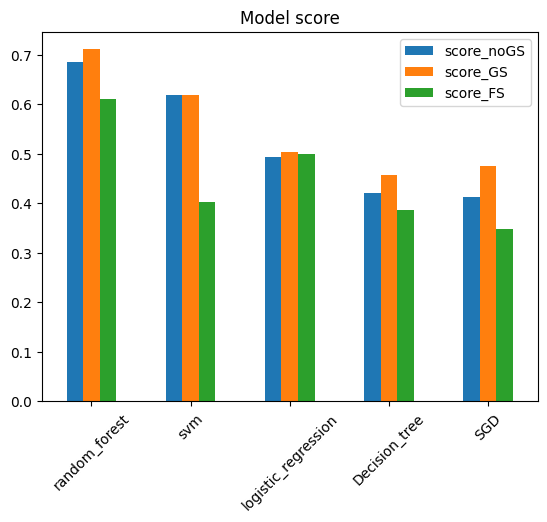

In [59]:
performance_all[['score_noGS','score_GS','score_FS']].plot(kind = 'bar').set(title = 'Model score')
plt.xticks(rotation= 45)


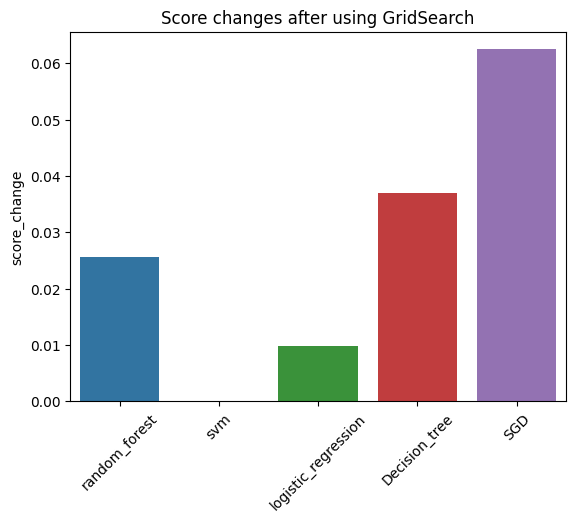

In [60]:
score_diff = pd.DataFrame(performance_all.score_GS-performance_all.score_noGS)
score_diff = score_diff.rename(columns={0:'score_change'})
sns.barplot(data=score_diff, x = score_diff.index,y = score_diff.score_change).set(title = 'Score changes after using GridSearch')
plt.xticks(rotation= 45)
plt.show();

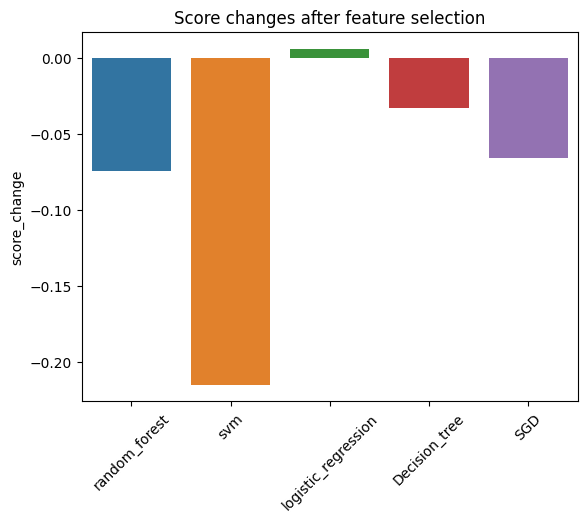

In [61]:
score_diff = pd.DataFrame(performance_all.score_FS-performance_all.score_noGS)
score_diff = score_diff.rename(columns={0:'score_change'})
sns.barplot(data=score_diff, x = score_diff.index,y = score_diff.score_change).set(title = 'Score changes after feature selection')
plt.xticks(rotation= 45)
plt.show();

In [62]:

prec_recall_nogs, prec_recall_gs,prec_recall_fs = {},{},{}

for i in performance_nogs.estimator_noGS:
    model = i
    model.fit(X_train,y_train)
    y_hat = model.predict(X_test)
    prec_recall_nogs[model] = {'Precision': precision_score(y_test,y_hat),'Recall': recall_score(y_test,y_hat)}

for i in performance_gs.estimator_GS:
    model = i
    model.fit(X_train,y_train)
    y_hat = model.predict(X_test)
    prec_recall_gs[model] = {'Precision': precision_score(y_test,y_hat),'Recall': recall_score(y_test,y_hat)}

for i in performance_fs.estimator_FS:
    model = i
    model.fit(X_train_fs,y_train)
    y_hat = model.predict(X_test_fs)
    prec_recall_fs[model] = {'Precision': precision_score(y_test,y_hat),'Recall': recall_score(y_test,y_hat)}
# performance_nogs

In [63]:
prec_recall_nogs = [{'Model':model,'Precision_nogs':scores['Precision'],'Recall_nogs':scores['Recall']} for model, scores in prec_recall_nogs.items()]
prec_recall_gs = [{'Model':model,'Precision_gs':scores['Precision'],'Recall_gs':scores['Recall']} for model, scores in prec_recall_gs.items()]
prec_recall_fs = [{'Model':model,'Precision_fs':scores['Precision'],'Recall_fs':scores['Recall']} for model, scores in prec_recall_fs.items()]

In [64]:
prec_recall_nogs

[{'Model': RandomForestClassifier(),
  'Precision_nogs': 0.4375,
  'Recall_nogs': 0.14},
 {'Model': SVC(), 'Precision_nogs': 0.0, 'Recall_nogs': 0.0},
 {'Model': LogisticRegression(),
  'Precision_nogs': 0.6666666666666666,
  'Recall_nogs': 0.08},
 {'Model': DecisionTreeClassifier(),
  'Precision_nogs': 0.3103448275862069,
  'Recall_nogs': 0.36},
 {'Model': SGDClassifier(), 'Precision_nogs': 0.64, 'Recall_nogs': 0.32}]

In [65]:
model = ['RandomForest','SVC','LogisticRegression','DecisionTree','SGD']
precRecall_nogs = pd.DataFrame(prec_recall_nogs).drop(columns='Model')
precRecall_nogs.index = model

precRecall_gs = pd.DataFrame(prec_recall_gs).drop(columns='Model')
precRecall_gs.index = model

precRecall_fs = pd.DataFrame(prec_recall_fs).drop(columns='Model')
precRecall_fs.index = model
# prec_recall_nogs

In [66]:
precRecall_all = pd.concat([precRecall_nogs,precRecall_gs,precRecall_fs],axis = 1)
prec_all = precRecall_all[['Precision_nogs','Precision_gs','Precision_fs']]
recall_all = precRecall_all[['Recall_nogs','Recall_gs','Recall_fs']]

# .reindex(columns = ['estimator_GS','best_params_GS','estimator_FS','best_params_FS','score_noGS','score_GS','score_FS'])
precRecall_all.reindex(columns = ['Precision_nogs','Precision_gs','Precision_fs','Recall_nogs','Recall_gs','Recall_fs'])

,Precision_nogs,Precision_gs,Precision_fs,Recall_nogs,Recall_gs,Recall_fs
RandomForest,0.437500,0.571429,0.529412,0.14,0.08,0.18
SVC,0.000000,0.000000,0.428571,0.00,0.00,0.06
LogisticRegression,0.666667,0.666667,0.800000,0.08,0.08,0.08
DecisionTree,0.310345,0.386364,0.484848,0.36,0.34,0.32
SGD,0.640000,0.485294,0.263889,0.32,0.66,0.38


<Axes: >

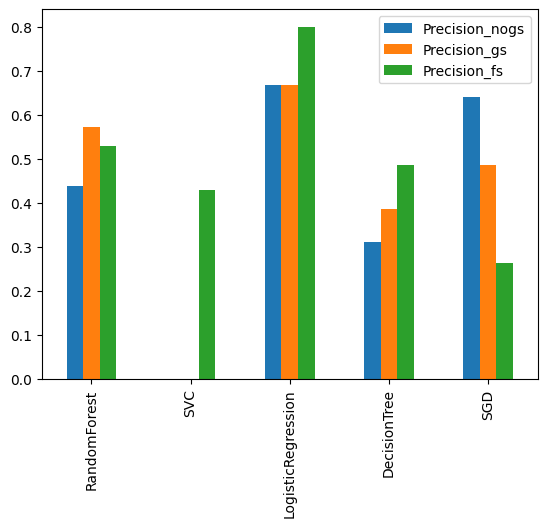

In [67]:
prec_all.plot(kind='bar')

<Axes: >

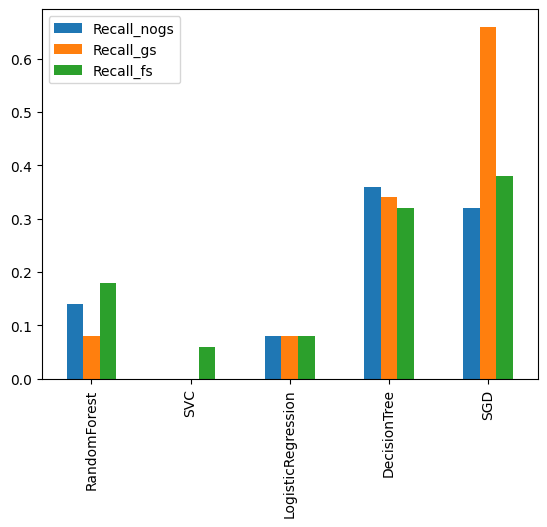

In [68]:
recall_all.plot(kind='bar')

# XGBoost

In [69]:
boost_clf = XGBClassifier()

In [70]:
boost_clf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [71]:
pred = boost_clf.predict(X_test)

In [72]:
accuracy_score(y_test,pred)

0.8585858585858586

In [74]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       247
           1       0.62      0.42      0.50        50

    accuracy                           0.86       297
   macro avg       0.75      0.68      0.71       297
weighted avg       0.84      0.86      0.85       297



In [75]:
y_prob = boost_clf.predict_proba(X_test)[:,1]

In [76]:
fpr,tpr,thresholds = roc_curve(y_test,y_prob)
roc_auc = auc(fpr,tpr)

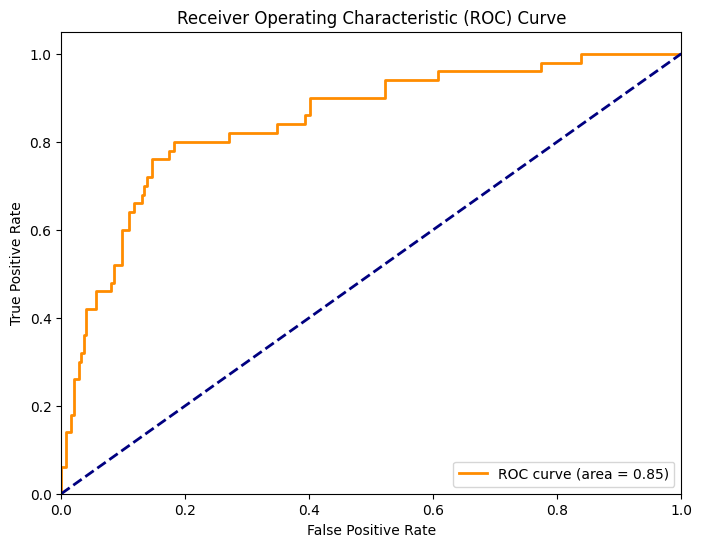

In [77]:
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='darkorange',lw=2,label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [82]:
### Fine-Tuning Model

recall = []
precision = []
for i in range(1,40):

    model =XGBClassifier(scale_pos_weight = i)
    
    model.fit(X_resampled,y_resampled)

    pred = model.predict(X_test)
    
    recall.append(recall_score(y_test,pred))
    precision.append(precision_score(y_test,pred))

In [84]:
max(recall),max(precision)

(0.66, 0.54)